# Multiclass classification of hummed and whistled songs using the Queen Mary MLEnd Hums & Whistles Dataset

In [8]:
#import all useful libraries used in this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as metrics


# 1 Author

**Name**:  Achal Mittal



# 2 Problem formulation

The problem that will be attempted in this notebook is of identifying a user recorded hum or whistle as one of eight songs using machine learning. This will be a multi-class classification problem. Given an input of a hum or a whistle by a user, the objective is to identify the recording as one of the following:

- Hakuna
- Rain
- Showman
- Mamma
- Frozen
- Panther
- Potter
- StarWars

This is a very interesting problem as 'Query by humming' is an ongoing research topic (and has been for a long time), and yet there are very few deployed solutions (most popular being Google and Soundhound) out in the world where a user can hum or whistle a song and a system identifies the tune correctly. The scope of this notebook is to explore a possible machine learning solution that can work on the limited number of songs above using the dataset provided. Learnings from the binary classification notebook ('AudioML - Binary classification - Potter vs StarWars.ipynb' - from this point forward referred to as 'basic solution') will be applied here as feature selection/exploration was carried out rigorously in that notebook to identify suitable features for a high accuracy binary classification. 

Please note that a lot of the sections in this notebook are very similar (especially Sections 3 - 6) to the basic solution (Potter vs StarWars) as the same methodology and pipeline philosophy have been applied here but only scaled up. A lot of work was done for the basic solution to find the ideal features (and models) that can accurately distinguish between recordings regardless of it being a hum or a whistle, and the learnings have been reused here.

# 3 Machine Learning pipeline

It is important to define the term 'pipeline' as it is used differently by different people in machine learning context. A 'pipeline' in the context of the problem defined above is defined as a sequence of instructions that will allow an input (user recorded hum or whistle) to be classified as one of the eight songs listed above. The pipeline is what will be deployed (not in scope of this project) in the real world as part of an app or any other tool for users to use, and contains the features and the models that have been selected after rigorous experimentation and evaluation. The process for finalising the pipeline is discussed in Section 6 - Methodology.

The machine learning pipeline that has been recommended for implementation in this notebook is shown as a flowchart below:

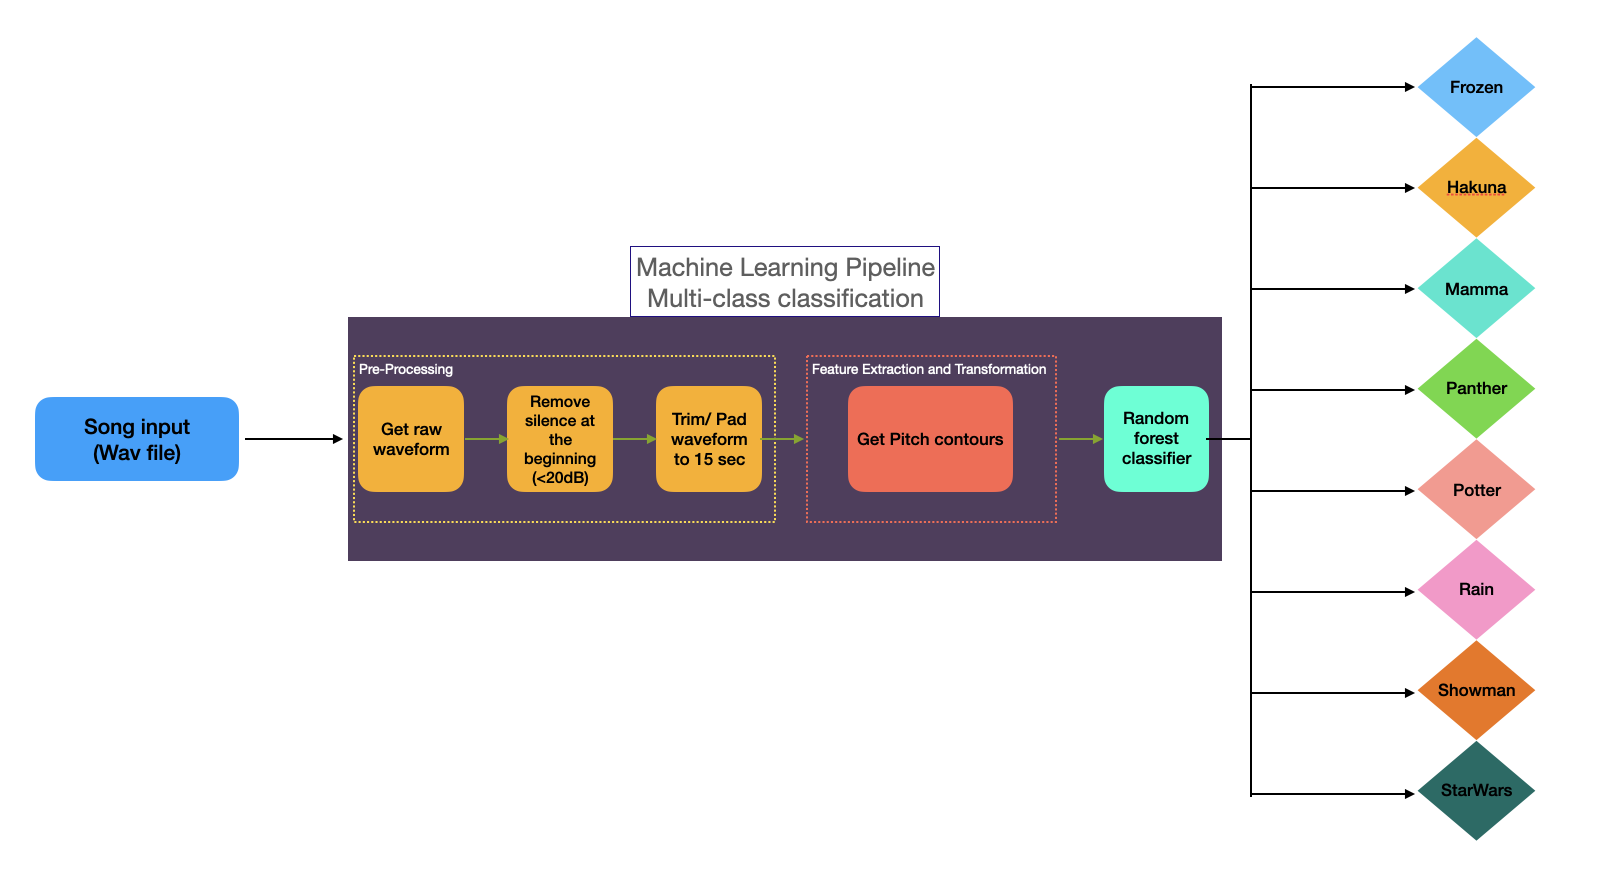

In [3]:
#display pipeline
display(Image(filename = "/Users/achalmittal/Desktop/Github repositories/QMUL_DSAI/ECS7020P - Principles of Machine Learning/Mini Project/multi_pipeline.png"))

Going through the steps shown above in order and giving a brief description:

- `Song input` - The input should be a .wav file, containing a recording of humming or whistling of a song by a user. 
- `Pre-processing`:
    - `Get raw waveform` - The .wav file is read in and the raw waveform (sampled at 44.1kHz) is saved as a numpy array.
    - `Remove silence at the beginning` - Silence has been defined as any sound less than 20dB in this solution. The function implemented finds the first instance (sample) in a waveform that is over 20dB and saves the input waveform starting at this point. The reason for this step is because the silence at the start of a recording does not provide any useful information. In addition, it helps in aligning the starting point of a song which helps in gaining useful and important information from the extracted features (that are time based - discussed below).
    - `Trim/Pad waveform` - Once the first non-silent sample is found in the recording, the next 15 seconds are saved. The waveform data is either trimmed to 15 sec or padded to 15 sec with zeros if the length of the recording is not long enough.
- `Feature Extraction/ Transformation`:
    - `Pitch contour extraction` - The features used in the pipeline are called pitch contours. They are discussed in more detail in Section 4 - Transformation stage. In terms of the data transformation, the trimmed waves from the previous step are split into frames based on a frame size and a hop length. In each frame, the fundamental frequency (f0) of the frame is found and saved. The resulting array (which can be considered a transformed downsample - it is of a much smaller length than the input) consists of the fundamental frequency for each frame. This vector will be the input to the model with the f0 values per frame being the features.
- `Classification using Random Forest` - Finally, the transformed data is fed into the classifier that has been chosen for the pipeline (discussed in detail in Sections 5 and 6) and will predict a label for the song.

# 4 Transformation stage

This section will discuss the features used in the pipeline, and any associated transformations. Learnings from the basic solution (Potter vs StarWars) was applied here as the best features to distinguish the melodies was found after rigorous experimentation in that notebook. Experiments carried out with other features (onset strength) can be found in the appendix (Section 10).

Pitch contours define how the the fundamental frequency changes over time. A visualisation is shown in Section 7 - Dataset. Pitch contours, theoretically, capture the high level melodic content as perceived by humans in an audio signal, and would therefore be suitable for the task of distinguishing one song from another.

The input is a waveform sampled at 44.1kHz and trimmed to 15 sec with no silence at the start of the recording (reasons discussed above). The pitch contours are extracted from the trimmed waveform using [librosa's pyin function](https://librosa.org/doc/main/generated/librosa.pyin.html) that estimates the fundamental frequency for every frame analysed within the input signal. The frame length in the pipeline has been defined as 8192 which equates to 186 ms of audio per frame. The hop length (how much to shift after each frame has been analysed) has been defined as half the frame length. This results in 50% overlap between frames (it's important to make the signals stationary). For 44100 samples per second in a 15 sec input, the number of fundamental frequencies that will be captured will equate to around 162. These are the no. of features that will be used. 

Thus, the input was a raw waveform of 661500 (15 sec * 44100 samples/sec) amplitude values and the output is a series of 162 fundamental frequencies (one per frame analysed).

The pitch contours can have 'Nan' values after extraction and hence the 'Nan' values are replaced with zeros. This is the final output that is fed into the model.

# 5 Modelling

It is intuitive to think that any ML model for this problem will need to be able to assess the similarity between the fundamental frequencies for a given frame for different inputs to determine a label. Thus, classifiers such as kNN (distance based similarity), and Random Forest (using features to determine useful information gain) were obvious choices for experimentation. They are also inherently multi-class capable. Since they performed really well in the basic solution (Potter vs StarWars), they will be used here as well. The models were evaluated against each other using test data (see Section 6 and Section 8) and Random Forest was deemed to be the better algorithm for the pipeline.

With the dataset used in this problem, and the features that are input into the model, the classifier is able to find features (fundamental frequency per frame) where maximum useful information (using the gini index) can be gained to predict the label of the song correctly.

# 6 Methodology

The below shows the workflow that was applied on this project which led to the final pipeline that has been recommended/ implemented in this notebook:

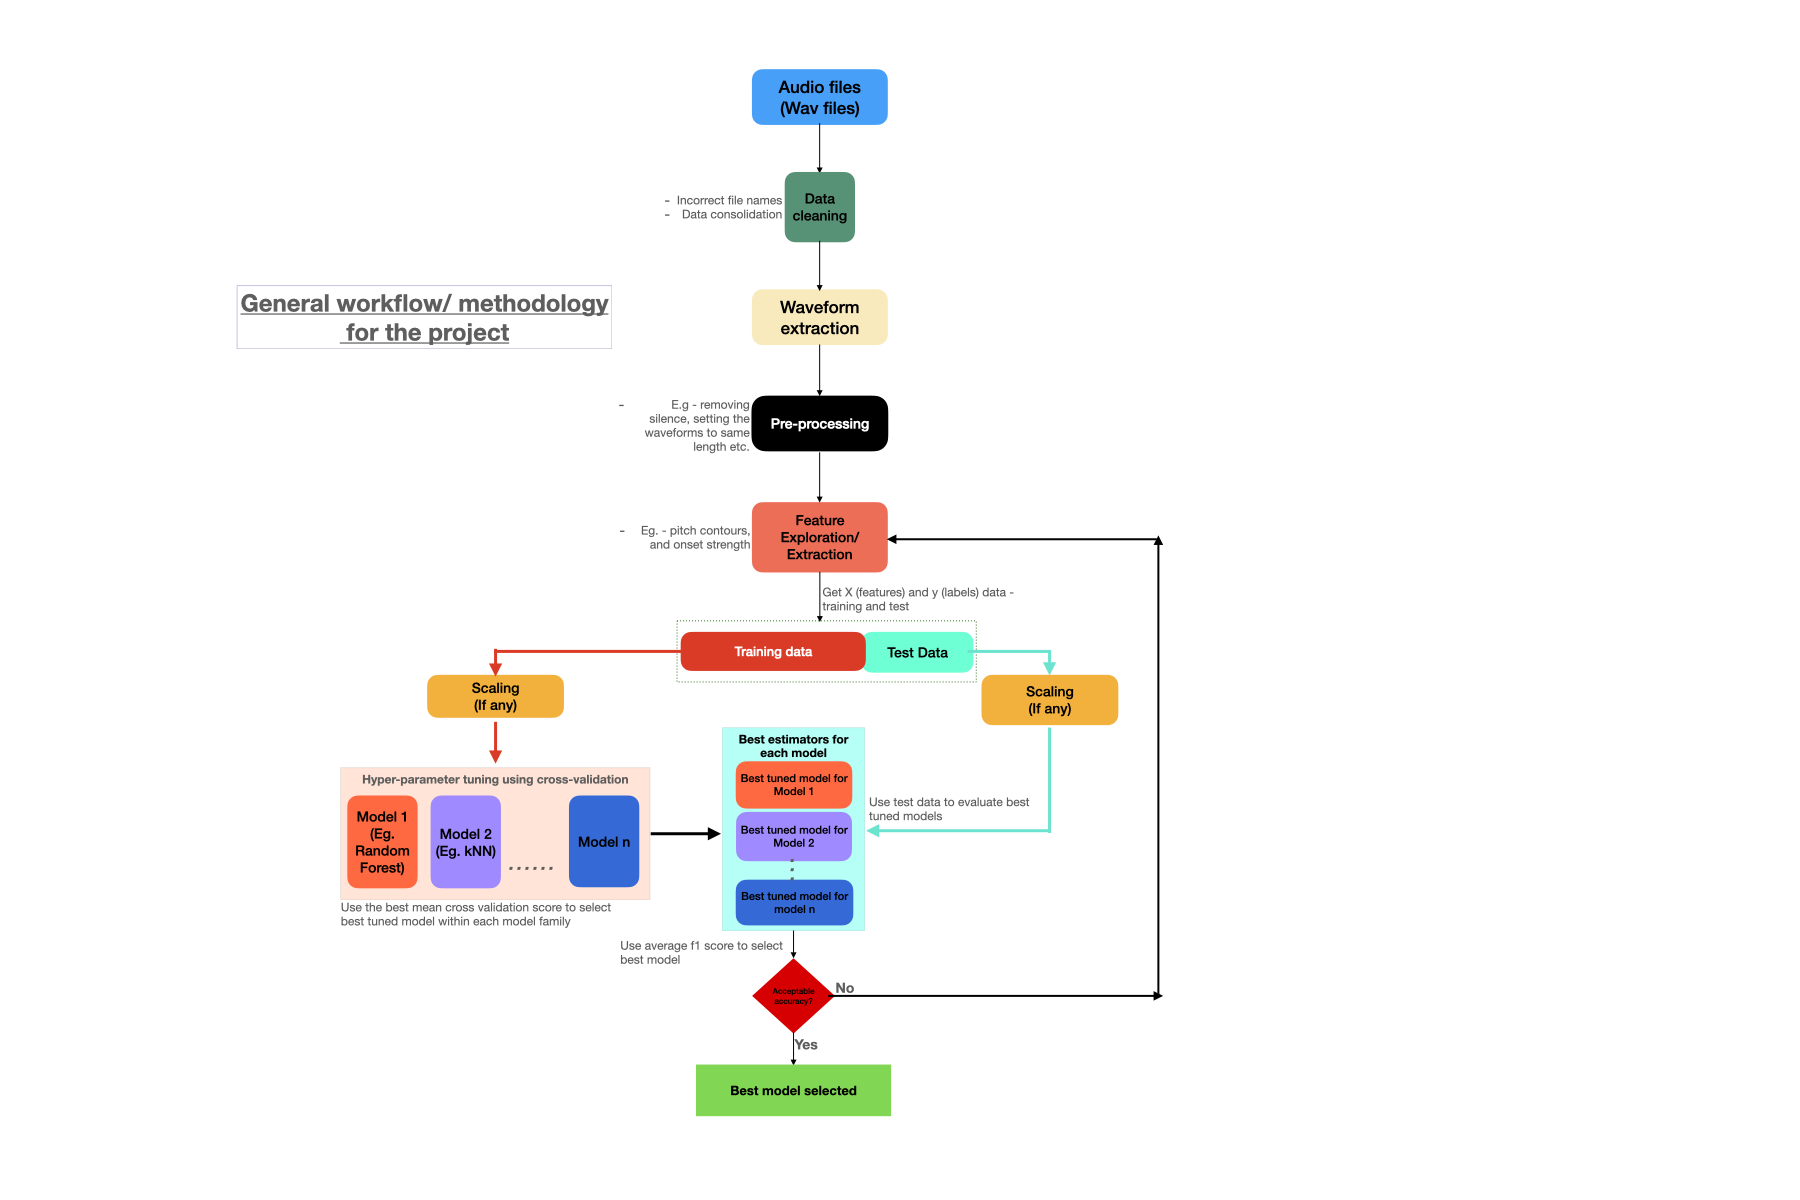

In [13]:
#display workflow/ methodology

display(Image(filename="/Users/achalmittal/Desktop/Github repositories/QMUL_DSAI/ECS7020P - Principles of Machine Learning/Mini Project/workflow_multiclass2/workflow_multiclass2.001.png"))

A few important points to note from the above (the rest should be self-explanatory from the diagram):

- `Pre-processing` - Tasks such as silence removal and trimming were carried out for all the data. As mentioned before, this was to get as much useful data as possible from the waveforms in the feature extraction stage. In addition, the trimming ensured that all samples were of equal length. This was an important consideration as each feature vector in the input X array needed to be of the same size. Most of the features that were experimented with were properties of the audio signal in a given frame within the signal.
- Multiple different models (algorithms) were evaluated. The hyperparameters for each algorithm were tuned using a [randomised search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) or [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) k-fold cross validation. Training data (see diagram above) was used for this purpose. The mean cross validation score was used to select the best tuned model. The best tuned model for each algorithm were then compared against one another by using the average f1 score obtained from using the test data. The algorithms that were used included Random Forest, and kNN (k-nearest neighbors). Other models (such as quadratic discriminant analysis, logistic regression, and naive bayes) were used during initial experimentation but were discarded soon after due to poor performance/ unsuitability.
- `Feature exploration/ extraction` -  This was the most crucial part of the process and was heavily explored during the basic solution (Potter vs Star Wars). If the features were not robust enough to distinguish between two songs, they wouldn't be suitable for 8 songs. As such, the best performing features were re-evaluated here. These were pitch contours, and onset strength. Pitch contours again (as with the basic solution) was the best feature set, and hence has been implemented in the pipeline. Both these features (onset strength and pitch contours) were evaluated using the accuracies obtained by the machine learning models.
- Experiments with and without scaling were performed and non-scaled data performed better and hence scaling is not part of the pipeline but part of the workflow.
- The final model with the final features were then selected for the pipeline.

# 7 Dataset

The MLEnd Hums and Whistles public dataset v0 was used for this project. All the available data was used. 30% of the data was reserved as a 'test' set to compare different models and choose the best (see Methodology diagram above).

In this section, pre-processing of the full dataset (all parts) will be carried out, the features to be used will be extracted, and the dataset will be separated into 'training' (used for hyperparameter tuning using cross validation), and 'test' data (for final model selection). For conciseness and simplicity, not all experiments/ iterations (as discussed in the previous section) will be included here, only some interesting ones (see Section 10 - Appendix for other features that were explored). 

## 7.1 Data loading, cleaning, and pre-processing

<b> Note that the all the code in this notebook uses paths local to the machine of the author and hence will be unrunnable. Outputs (where necessary) have been included. </b>

In [6]:
#create paths
os.chdir('/Users/achalmittal/Downloads')
path = os.getcwd()
hakuna_path_2 = path + '/Hakuna_2/*'
showman_path_2 = path + '/Showman_2/*'
hakuna_path_1 = path + '/Hakuna_1/*'
showman_path_1 = path + '/Showman_1/*'
mamma_path_2 = path + '/Mamma_2/*'
frozen_path_2 = path + '/Frozen_2/*'
mamma_path_1 = path + '/Mamma_1/*'
frozen_path_1 = path + '/Frozen_1/*'
rain_path_2 = path + '/Rain_2/*'
panther_path_2 = path + '/Panther_2/*'
rain_path_1 = path + '/Rain_1/*'
panther_path_1 = path + '/Panther_1/*'
potter_path_1 = path + '/Potter_1/*'
potter_path_2 = path + '/Potter_2/*'
starwars_path_1 = path + '/StarWars_1/*'
starwars_path_2 = path + '/StarWars_2/*'
path_list = [hakuna_path_1,hakuna_path_2,rain_path_1,rain_path_2,showman_path_1,showman_path_2,mamma_path_1,mamma_path_2,
frozen_path_1,frozen_path_2,panther_path_1,panther_path_2,potter_path_1,potter_path_2,starwars_path_1,starwars_path_2]

In [ ]:
#helper functions to clean/rename original files
def clean_file_names(path, song):
    """In path (string), find files that don't conform to the format: [StudentID]_[interpretation]_[interpretation number]_[song]
    and rename them to this format. Returns list of all corrected files with their index in the original list.
    Ensure song input is in the correct format eg. StarWars or Potter"""
    file_paths = glob.glob(path)
    file_names = [file.split('/')[-1] for file in file_paths]
    wrong_files = [[i,file_names[i]] for i in range(len(file_names)) if not re.fullmatch('^[S][0-9]+_(hum|whistle)_[0-9]_'+ song +'.wav',file_names[i])]
    corrected_files = []
    for item in wrong_files:
        item[1] = item[1].replace(" ", "").replace("[", "").replace("]","").upper() #remove spaces, brackets, and convert eveything to uppercase
        s_id = item[1].split('_',1)[0] #get student id
        rest = item[1].split('_',1)[1] #get rest of string
        int_num = re.search('[0-9]',rest).group() #get the interpretation number from the rest of the string
        if 'HUM' in rest: #assumption that no one has spelt 'hum' wrong in their original submission
            corrected_files.append([item[0], s_id+'_hum_'+int_num+'_'+song+'.wav'])
        else:
            corrected_files.append([item[0], s_id+'_whistle_'+int_num+'_'+song+'.wav'])
    
    return corrected_files

def rename_files(path,list_of_filenames):
    """Path is the directory where all the files reside. Ensure path ends in '/*' to find all the files. 
    list_of_filenames is a list of lists. Each sublist consists of index of the original file and the new file name."""
    file_paths = glob.glob(path) #get original file paths
    file_names = [file.split('/')[-1] for file in file_paths] #get original filenames
    [os.rename(path.rstrip('*') + file_names[f[0]], path.rstrip('*') + f[1]) for f in list_of_filenames] 
    return None

#only need to run the below once.
# for song_path in path_list:
#     corrected_files = clean_file_names(song_path,song_path.split('/')[-2].split('_')[0])
#     rename_files(song_path, corrected_files)

In [ ]:
file_list = []
for song_path in path_list:
    file_list += glob.glob(song_path)

songs_table = [] 

for file in file_list:
  location = file.rpartition('/')[0] + file.rpartition('/')[1]
  file_name = file.rpartition('/')[-1]
  participant_ID = file.split('/')[-1].split('_')[0]
  interpretation_type = file.split('/')[-1].split('_')[1]
  interpretation_number = file.split('/')[-1].split('_')[2]
  song = file.split('/')[-1].split('_')[3].split('.')[0]
  songs_table.append([location, file_name,participant_ID,interpretation_type,interpretation_number, song])

In [ ]:
#create dataframe and add class labels
songs_df = pd.DataFrame(songs_table,columns=['location','file_id','participant','interpretation','number','song']).set_index('file_id') 
songs_df.song = songs_df.song.astype('category')
songs_df = songs_df.assign(class_label = songs_df.song.cat.codes)
songs_df

,location,participant,interpretation,number,song,class_label
file_id,,,,,,
S10_hum_2_Hakuna.wav,/Users/achalmittal/Downloads/Hakuna_1/,S10,hum,2,Hakuna,1
S72_whistle_2_Hakuna.wav,/Users/achalmittal/Downloads/Hakuna_1/,S72,whistle,2,Hakuna,1
S17_hum_1_Hakuna.wav,/Users/achalmittal/Downloads/Hakuna_1/,S17,hum,1,Hakuna,1
S93_hum_2_Hakuna.wav,/Users/achalmittal/Downloads/Hakuna_1/,S93,hum,2,Hakuna,1
S114_hum_2_Hakuna.wav,/Users/achalmittal/Downloads/Hakuna_1/,S114,hum,2,Hakuna,1
...,...,...,...,...,...,...
S190_hum_2_StarWars.wav,/Users/achalmittal/Downloads/StarWars_2/,S190,hum,2,StarWars,7
S164_hum_1_StarWars.wav,/Users/achalmittal/Downloads/StarWars_2/,S164,hum,1,StarWars,7
S135_hum_2_StarWars.wav,/Users/achalmittal/Downloads/StarWars_2/,S135,hum,2,StarWars,7


In [ ]:
#check if dataset is balanced
songs_df.song.value_counts()

Panther     418
Potter      417
Rain        417
StarWars    417
Hakuna      416
Mamma       416
Frozen      414
Showman     414
Name: song, dtype: int64

It can be seen that classes are divided equally (more or less) and hence the dataset can be considered balanced. This means a simple accuracy score can be used to assess the quality of a machine learning model that uses this dataset.

The data filenames have been cleaned, and loaded. Next, pre-processing (get waveforms, remove silence, and trim/pad the signals) will be carried out:

In [ ]:
#get waveform data and time data
def get_waveforms(file_path_list,fs = None):
    waveforms = []
    for i in file_path_list:
        # Sampling frequency - None uses native sampling rate -44100 in our case
        x, fs = librosa.load(i,sr=fs)
        waveforms.append(x)
    return waveforms, fs
waveforms, fs = get_waveforms(file_list)

Since the features (pitch contours) are going to be defined per frame, the audio files need to be of a consistent length to get the same number of frames. Any silence (useless information) in the beginning of all audio files is removed and 15 sec of audio from the onset of first sound is saved:

In [ ]:
#get first instance where audio file is not silent. Then get the next 15 seconds (for sample rate of 44100/sec, 15 sec = 661500 samples)
def trim_audio(audio_waveform, sr=44100, length = 15, silence_db = 20):
    """Takes an audio waveform (array/list) of sample rate sr, removes silence from the beginning of the file, and gets the next 15sec. 
    Pads zeros to the right if start of non silent portion + 15 sec is greater than the original length of the file. 
    Returns trimmed waveform data."""
    start_sample = librosa.effects.split(audio_waveform, top_db = silence_db)[0][0] #the first sample where there is no silence
    if len(audio_waveform) < start_sample + (length * sr):
        trimmed_wave = audio_waveform[start_sample:]
        trimmed_wave = librosa.util.fix_length(trimmed_wave,length*sr)
    else:
        trimmed_wave = audio_waveform[start_sample:start_sample+(length*sr)]
    return trimmed_wave

In [ ]:
#get the trimmed waves
trimmed_waves = [trim_audio(wave, sr = 44100, length = 15, silence_db= 20) for wave in waveforms]
trimmed_waves = np.asarray(trimmed_waves)
trimmed_waves.shape

(3329, 661500)

We see that the trimmed waves array has 3329 data points (recordings) with each data point consisting of 661500 samples.

## 7.2 Feature exploration/ extraction

The features that were evaluated for this project included onset strength and pitch contours. For simplicity and conciseness, only the pitch contours features will be extracted and explored here. Experimentation with onset strength is included in the appendix (for interest only).

Reference to paper that inspired the use of pitch contours as a possible solution: https://www.mdpi.com/2076-3417/8/4/507/htm

Extracting the pitch contours for all waveforms:

In [ ]:
#Extract pitch (f0) for all data
n_fft = 8192 #8192 frame length equates to ~186ms per frame. 4410 equates to 100ms.
def get_pitch(audio_waveform, frame_length = 8192, sr = 44100, fmin =65, fmax = 2093):
    f0, vf, vb = librosa.pyin(y=audio_waveform, sr=sr, fmin = fmin, fmax = fmax, frame_length=frame_length,hop_length=frame_length//2)
    return f0

In [ ]:
f0 = [get_pitch(wave) for wave in trimmed_waves]
f0 = np.vstack(f0)
#important to carry this out - replaces NaNs with 0s
np.nan_to_num(f0,copy = False)
f0.shape

(3329, 162)

Thus, our data consists of 3329 samples and 162 features.

Visualising the pitch contours superimposed on a spectogram (visual depiction of a frequency spectrum over time) for a random song:

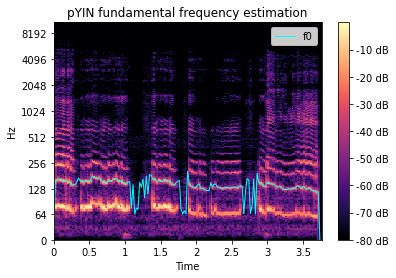

In [ ]:
#plot spectogram and overlay with fundamental frequency envelope
D = librosa.amplitude_to_db(np.abs(librosa.stft(trimmed_waves[28], n_fft = 8192, hop_length = 8192//2)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
times = librosa.times_like(f0[28])
ax.plot(times, f0[28], label='f0', color='cyan', linewidth=1)
ax.legend(loc='upper right')

The above shows that the underlying 'melody' (changes in pitch over time) of the song is captured well by the fundamental frequencies (blue line). Note that fundamental frequency extraction can result in Nan values. These need to be replaced. The sudden dips in the above chart are because the nan values were replaced. 

The above features can now be used to train different models for classification purposes. However, since multiple models will be evaluated, the data needs to be split between training and testing:

In [ ]:
#get y data
y = songs_df.class_label.values

#train, test split f0
X_train, X_test, y_train, y_test = train_test_split(f0,y,test_size=0.3)

#create dictionary for label and target class name to be used for confusion matrix/ f1 scores later
labels_dict = dict(zip(songs_df.class_label.unique(),songs_df.song.unique()))

print("Shapes: X_train: {}; y_train: {}; X_test: {}; y_test: {}".format(X_train.shape,y_train.shape,X_test.shape,y_test.shape))

Shapes: X_train: (2330, 162); y_train: (2330,); X_test: (999, 162); y_test: (999,)


# 8 Results

In this section, the training data will be used for cross validation of the above mentioned models to obtain the best tuned model for each family (using the best mean cross validation accuracy score). The test data will be used to test the best tuned models from each family. The f1 score and the confusion matrix will be used to determine the best model for the pipeline. As mentioned before accuracy score can be used as the dataset is balanced but it will be interesting to note which songs the classifiers find easy to classify and which they struggle with.

For reference, the class labels and the songs associated with the labels are displayed below to aid in the interpretation of the confusion matrices:

In [ ]:
#display the labels and associated song name for reference - helps with interpretating the confusion matrices below
labels_dict

{1: 'Hakuna',
 5: 'Rain',
 6: 'Showman',
 2: 'Mamma',
 0: 'Frozen',
 3: 'Panther',
 4: 'Potter',
 7: 'StarWars'}

## 8.1 Using hyperparameter optimisation and cross fold validation:

### kNN:

Grid search cross validation is used to exhaustively search all the parameters in a defined search space and return the best tuned model.

In [ ]:
# no. of k-neighbours to consider
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
# weighting type
weights = ['uniform', 'distance']
#algorithm to use
algorithm = ['auto']#, 'ball_tree', 'kd_tree']
# # leaf size for ball tree or kd tree algorithms
# leaf_size = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
#create grid
grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': algorithm}
            #    'leaf_size': leaf_size}

knn = neighbors.KNeighborsClassifier()
knn_grid = GridSearchCV(estimator = knn, param_grid = grid, cv = 10, verbose = 1, n_jobs = -1, return_train_score=True)
knn_grid.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, verbose=1)

Mean training score for the best estimator:  1.0
Mean cross validated score for the best estimator:  0.6206008583690987
Test accuracy (test dataset) using best model: 0.6126126126126126
Best model's parameters:  {'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'distance'}


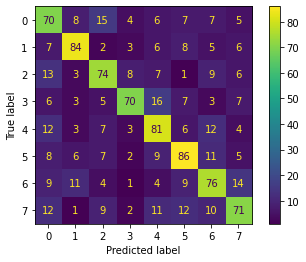

<AxesSubplot:>

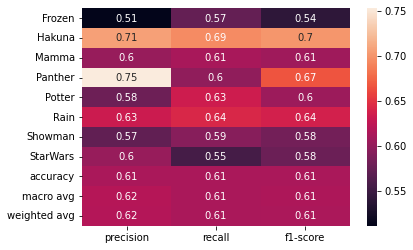

In [ ]:
best_grid = knn_grid.best_estimator_
mean_train_accuracy = knn_grid.cv_results_["mean_train_score"][knn_grid.best_index_] #mean training accuracy for best model
mean_val_accuracy = knn_grid.cv_results_["mean_test_score"][knn_grid.best_index_] #mean cross validated accuracy for best model
y_pred_val = best_grid.predict(X_test) #keep prediction values for y
test_accuracy = best_grid.score(X_test,y_test) #test accuracy on test data
print('Mean training score for the best estimator: ', mean_train_accuracy)
print('Mean cross validated score for the best estimator: ', mean_val_accuracy)
print("Test accuracy (test dataset) using best model: {}".format(test_accuracy))
print("Best model's parameters: ", knn_grid.best_params_)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_val,labels=best_grid.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix, display_labels = best_grid.classes_)
disp.plot()
plt.show()
target_names = [labels_dict[i] for i in best_grid.classes_]
class_report = metrics.classification_report(y_test, y_pred_val,labels=best_grid.classes_, target_names=target_names, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1,:].T, annot=True)

The following is noted from the above results:
- The model has been overfitted by quite a lot as the training accuracy is 100% and the mean validation accuracy is only 62% indicating that the model will not generalise well to unseen data.
- The test dataset (30% of the original dataset not seen by the model) has an average f1 score of 61% which is not very good as it indicates a high false positive and false negative rate (as reflected in the average precision and recall scores as well).
- Frozen has the worst precision, i.e., almost half of the recordings that were labelled as Frozen were labelled incorrectly. 
- StarWars has the worst recall , i.e., 45% of the actual star wars recordings were not identified as StarWars.
- Panther has the best precision whereas Hakuna has the best recall. Hakuna also has the highest F1 score indicating that it was the easiest song for the kNN model to identify.

### Random Forest:

Randomised search cross validation is used first as grid search is an exhaustive search and computationally expensive for Random forests. Once Randomised search has finished and pointed towards a more focussed area, grid search cross validation will be used for further optimisation. [This article](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) was used to come up with this method.

In [ ]:
# Randomised Search - Cross validation
# define search space for randomised_search_cv

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 10, verbose = 1, n_jobs=-1, return_train_score= True)
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/Users/achalmittal/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 14, 26, 38, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17, 20],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20],
                                        'n_estimators': [50, 89, 129, 169, 209,
                                                         248, 288, 328, 368,
                                                         408, 447, 487, 527,
                                                         567

Mean training score for the best estimator:  1.0
Mean cross validated score for the best estimator:  0.7562231759656652
Test accuracy (test dataset) using best model: 0.7797797797797797
Best model's parameters:  {'n_estimators': 1442, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 26, 'bootstrap': False}


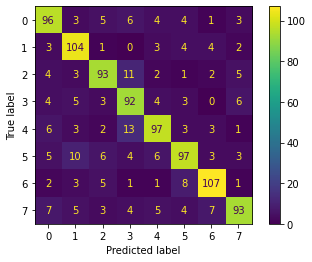

<AxesSubplot:>

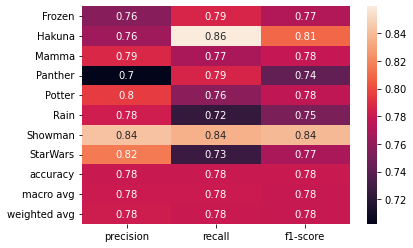

In [ ]:
best_random = rf_random.best_estimator_
mean_train_accuracy = rf_random.cv_results_["mean_train_score"][rf_random.best_index_] #mean training accuracy for best model
mean_val_accuracy = rf_random.cv_results_["mean_test_score"][rf_random.best_index_] #mean cross validated accuracy for best model
y_pred_val = best_random.predict(X_test) #keep prediction values for y
test_accuracy = best_random.score(X_test,y_test)
print('Mean training score for the best estimator: ', mean_train_accuracy)
print('Mean cross validated score for the best estimator: ', mean_val_accuracy)
print("Test accuracy (test dataset) using best model: {}".format(test_accuracy))
print("Best model's parameters: ", rf_random.best_params_)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_val,labels=best_random.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix, display_labels = best_random.classes_)
disp.plot()
plt.show()
target_names = [labels_dict[i] for i in best_random.classes_]
class_report = metrics.classification_report(y_test, y_pred_val,labels=best_random.classes_, target_names=target_names, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1,:].T, annot=True)


The mean cross-validation score is 75.6% but the mean training score is 100% indicating overfitting. The f1 score on the test data is 78%. The results of the best parameter from the above will be used to perform a focussed exhaustive grid search to see if the model can be improved. n_estimators will be increased, max depth will be reduced, min_samples leaf will be increased, and min_samples_split will be increased as well to reduce the risk of overfitting:

In [ ]:
# Number of trees in random forest
n_estimators = [1442, 1500, 1600]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [10,15]
# Minimum number of samples required to split a node
min_samples_split = [10,12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 10, verbose = 1, n_jobs=-1, return_train_score= True)
rf_grid.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 15],
                         'max_features': ['sqrt'], 'min_samples_leaf': [3],
                         'min_samples_split': [10, 12],
                         'n_estimators': [1442, 1500, 1600]},
             return_train_score=True, verbose=1)

Mean training score for the best estimator:  0.9985216976633285
Mean cross validated score for the best estimator:  0.7489270386266094
Test accuracy (test dataset) using best model: 0.7607607607607607
Best model's parameters:  {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 1500}


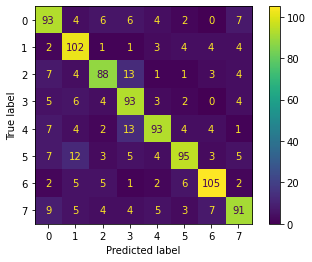

<AxesSubplot:>

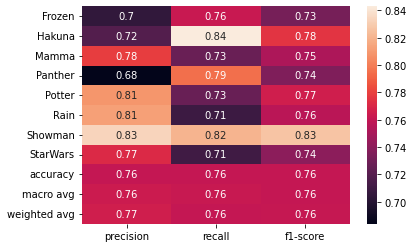

In [ ]:
best_grid = rf_grid.best_estimator_
mean_train_accuracy = rf_grid.cv_results_["mean_train_score"][rf_grid.best_index_] #mean training accuracy for best model
mean_val_accuracy = rf_grid.cv_results_["mean_test_score"][rf_grid.best_index_] #mean cross validated accuracy for best model
y_pred_val = best_grid.predict(X_test) #keep prediction values for y
test_accuracy = best_grid.score(X_test,y_test)
print('Mean training score for the best estimator: ', mean_train_accuracy)
print('Mean cross validated score for the best estimator: ', mean_val_accuracy)
print("Test accuracy (test dataset) using best model: {}".format(test_accuracy))
print("Best model's parameters: ", rf_grid.best_params_)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_val,labels=best_grid.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix, display_labels = best_grid.classes_)
disp.plot()
plt.show()
target_names = [labels_dict[i] for i in best_grid.classes_]
class_report = metrics.classification_report(y_test, y_pred_val,labels=best_grid.classes_, target_names=target_names, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1,:].T, annot=True)

The following is noted from the above results:
- Following a grid search cross validation, the model is still heavily overfitted but the training accuracy has gone down very slightly.
- The accuracy on the test data is very similar to mean cross-validated accuracy. While the accuracy is not great, it is decently high.  
- The average precision, recall, and f1-score all equate to around 76% which is again, decent. It indicates that on average, for any given class, 76% of the actual observations for the class were correctly predicted (recall), and for a given class 24% of the observations were incorrectly predicted to be that class (precision). 
- Showman has the highest F1 score, the highest precision, and the second highest recall ,i.e., very few were mislabelled as Showman, and very few Showman were not identified correctly. The model had the easiest time with Showman.
- Panther has the worst precision indicating that 32% of the Panther predictions were misclassified and were false positives. Looking at the confusion matrix, it's clear that both Potter (label 4) and Mamma (label 2) were the ones that the model confused with Panther the most.

While the above is not an ideal model in terms of its generalisation ability (due to overfitting), it still has a good average f1 score of 76% on the test data which is significantly higher than the kNN model's score (61%). Thus, this is the model that will be chosen for the pipeline.

In [ ]:
rf_model_chosen = rf_grid.best_estimator_

Defining a pipeline function using the above features and model to predict an audio recording as one of eight songs:

In [ ]:
def pipeline(audio_path_list, model = rf_model_chosen):
    """using the chosen model, predict the label for an audio located in the path in the audio_path_list (list)"""
    labels_dict = {0:'Frozen',1:'Hakuna',2:'Mamma',3:'Panther',4:'Potter',5:'Rain',6:'Showman',7:'StarWars'}
    waveform, fs = get_waveforms(audio_path_list) #get waveform
    trimmed_wave = [trim_audio(wave, sr = 44100, length = 15, silence_db= 20) for wave in waveform] #trim the wave
    trimmed_wave = np.asarray(trimmed_wave)
    f0 = [get_pitch(wave) for wave in trimmed_wave] #extract pitch contours
    f0 = np.vstack(f0)
    #important to carry this out - replaces NaNs with 0s
    np.nan_to_num(f0,copy = False)
    class_label = model.predict(f0) #predict label using the best model
    return class_label #1 for potter, 0 for starwars


# 9 Conclusions

A machine learning pipeline solving a multi-class classification problem of differentiating between the eight songs (listed in Section 2) has been proposed in this notebook. The machine learning model recommended in the pipeline has a test f1 score of ~76%. 

While the above score is ok, and the best that has been achieved after experimenting with various different features and models, there is still a lot of room for improvement: 
- Investigate the overfitting issue and try to reduce that.
- A domain expert in audio analysis/ engineering should be consulted to try and select better features. 
- Using techniques such as Convolutional Neural Networks (CNNs) in conjunction with features such as mel-spectograms or MFCC (mel frequency cepstrum coefficient) would be the next step to try and implement a more accurate pipeline.  
- Carry out an outlier analysis on the actual audio data. If there are 'prank' recordings or recordings that are not representative of target population, they should be discarded. This was not carried out in this project.
- Experiment with time series classifiers such as kNN with DTW (dynamic time warping) or Time series forest or Random Interval Spectral Ensemble that treat the data as a time series and preserve the sequence in which the features occur.

# 10 Appendix - For interest only

## 10.1 Feature exploration/ extraction experimentation

### 10.1.1 Onset strength/detection

Onset strength performed very well for the Potter vs StarWars basic solution (best after pitch contours). The test accuracy for that problem was around 81%. It will be interesting to see if it scales up well to a multi-song problem. The basic idea is to compute the onset strength envelope around an audio signal to detect when a note 'attacks' or 'appears'. 

In [ ]:
#Extract onset strength for all data
n_fft = 8192 #8192 frame length equates to ~186ms per frame. 4410 equates to 100ms.
def get_onset_str(audio_waveform, frame_length = 8192, sr = 44100, agg = np.median):
    return librosa.onset.onset_strength(y= audio_waveform, sr=sr, aggregate=agg, n_fft = frame_length, hop_length = frame_length//2)


In [ ]:
onsets = [get_onset_str(wave) for wave in trimmed_waves]
onsets = np.asarray(onsets)
onsets.shape
# np.save('onsets', onsets)

(3329, 162)

#### lets try and fit kNN and random forests with just onsets:

#### split data, get labels

In [ ]:
#train, test split onsets
X_train, X_val, y_train, y_val = train_test_split(onsets,y,test_size=0.3)

#### Using hyperparameter optimisation and cross fold validation:

#### Random Forest:

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 10, verbose = 1, n_jobs=-1, return_train_score= True)
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 14, 26, 38, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17, 20],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20],
                                        'n_estimators': [50, 89, 129, 169, 209,
                                                         248, 288, 328, 368,
                                                         408, 447, 487, 527,
                                                         567

Mean training score for the best estimator:  0.9987124463519313
Mean cross validated score for the best estimator:  0.5824034334763948
Test accuracy (test dataset) using best model: 0.5925925925925926
Best model's parameters:  {'n_estimators': 806, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}


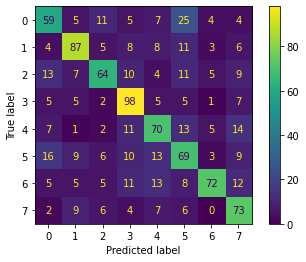

<AxesSubplot:>

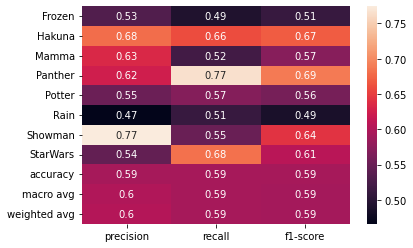

In [ ]:
best_random = rf_random.best_estimator_
mean_train_accuracy = rf_random.cv_results_["mean_train_score"][rf_random.best_index_] #mean training accuracy for best model
mean_val_accuracy = rf_random.cv_results_["mean_test_score"][rf_random.best_index_] #mean cross validated accuracy for best model
y_pred_val = best_random.predict(X_test) #keep prediction values for y
test_accuracy = best_random.score(X_test,y_test)
print('Mean training score for the best estimator: ', mean_train_accuracy)
print('Mean cross validated score for the best estimator: ', mean_val_accuracy)
print("Test accuracy (test dataset) using best model: {}".format(test_accuracy))
print("Best model's parameters: ", rf_random.best_params_)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_val,labels=best_random.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix, display_labels = best_random.classes_)
disp.plot()
plt.show()
target_names = [labels_dict[i] for i in best_random.classes_]
class_report = metrics.classification_report(y_test, y_pred_val,labels=best_random.classes_, target_names=target_names, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1,:].T, annot=True)


#### kNN:

In [ ]:
# no. of k-neighbours to consider
n_neighbors = [int(x) for x in np.linspace(start = 5, stop = 20, num = 15)]
# weighting type
weights = ['uniform', 'distance']
#algorithm to use
algorithm = ['auto']#, 'ball_tree', 'kd_tree']
# # leaf size for ball tree or kd tree algorithms
# leaf_size = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
#create grid
grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': algorithm}
               # 'leaf_size': leaf_size}

knn = neighbors.KNeighborsClassifier()
knn_grid = GridSearchCV(estimator = knn, param_grid = grid, cv = 10, verbose = 1, n_jobs = -1, return_train_score=True)
knn_grid.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/Users/achalmittal/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto'],
                         'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 20],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, verbose=1)

Mean training score for the best estimator:  0.9996185026227945
Mean cross validated score for the best estimator:  0.42832618025751074
Test accuracy (test dataset) using best model: 0.42342342342342343
Best model's parameters:  {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'distance'}


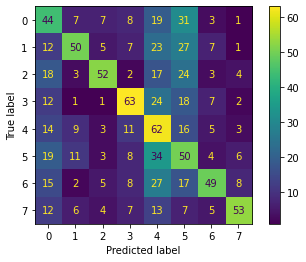

<AxesSubplot:>

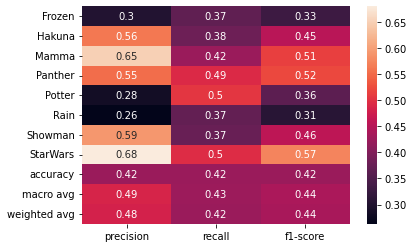

In [ ]:
best_grid = knn_grid.best_estimator_
mean_train_accuracy = knn_grid.cv_results_["mean_train_score"][knn_grid.best_index_] #mean training accuracy for best model
mean_val_accuracy = knn_grid.cv_results_["mean_test_score"][knn_grid.best_index_] #mean cross validated accuracy for best model
y_pred_val = best_grid.predict(X_test) #keep prediction values for y
test_accuracy = best_grid.score(X_test,y_test) #test accuracy on test data
print('Mean training score for the best estimator: ', mean_train_accuracy)
print('Mean cross validated score for the best estimator: ', mean_val_accuracy)
print("Test accuracy (test dataset) using best model: {}".format(test_accuracy))
print("Best model's parameters: ", knn_grid.best_params_)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_val,labels=best_grid.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix, display_labels = best_grid.classes_)
disp.plot()
plt.show()
target_names = [labels_dict[i] for i in best_grid.classes_]
class_report = metrics.classification_report(y_test, y_pred_val,labels=best_grid.classes_, target_names=target_names, output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1,:].T, annot=True)

#### We see that onsets don't work really well with multiple classes and we get validation accuracy of 60%% and 43% from RF and kNN respectively after performing cross validation.